<a href="https://colab.research.google.com/github/tomfirer/NLP_Project/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>NLP Final Project</h1>
<h7>By Tom Firer</h7>

In [1]:
!pip install datasets
!pip install bert-extractive-summarizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
#imports
from datasets import load_dataset
import pandas as pd
import numpy as np
import functools
import string
import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from scipy import sparse, spatial

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim.models import Word2Vec

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import spacy
from spacy import displacy

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import CosineSimilarity

from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline, BartTokenizer, BartForConditionalGeneration

from summarizer import Summarizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [30]:
### functions ###
def clean_text(corpus: list[str]) -> list[str]:
  new_corpus = []
  for document in corpus:
    document = re.sub(r'[^\w\s]', '', document)
    document = document.lower()
    new_corpus.append(document)
  return new_corpus


def tokenize_nltk(corpus: list[str]) -> list[list[str]]:
  token_mat = []
  for document in corpus:
    token_mat.append(nltk.word_tokenize(document))
  return token_mat


def remove_stopwords(token_mat: list[list[str]]) -> list[list[str]]:
  stop_words = stopwords.words('english')
  filtered_tokens = [[token for token in token_arr if token not in stop_words and token.isalpha()] for token_arr in token_mat]
  return filtered_tokens


def lemmatize_nltk(token_mat: list[list[str]]) -> list[list[str]]:
  lemmatizer = WordNetLemmatizer()
  lemmatized_res = []
  for token_arr in token_mat:
    lemmatized_res.append([lemmatizer.lemmatize(token) for token in token_arr])
  return lemmatized_res


#"untokenizes" a matrix of tokens back into an array of strings
def token_matrix_to_string_array(token_mat: list[list[str]]) -> list[str]:
  return [' '.join([str(x) for x in token_arr]) for token_arr in token_mat]


def tfidf_feature_extraction(corpus: list):
  vectorizer = TfidfVectorizer(stop_words=None, min_df=1, token_pattern=r"(?u)\b\w+\b")
  tfidf_mat = vectorizer.fit_transform(corpus)
  return (vectorizer, tfidf_mat)


#returns the most frequent words according to the greatest mean of tf-idf score across all documents
def get_most_frequent_words_tfidf(tfidf_vectorizer: TfidfVectorizer, tfidf_mat, n = 0) -> list[(str, float)]:
  mat = tfidf_mat.toarray()
  tfidf_arr = list(np.sum(mat, axis=0)/len(mat))
  tfidf_arr = [(word, score) for word, score in zip(tfidf_vectorizer.get_feature_names_out(), tfidf_arr)]
  tfidf_arr.sort(key=lambda x: x[1], reverse=True)
  if n == 0:
    n = len(tfidf_arr)
  return tfidf_arr[:n]


def show_important_words_bar_plot(word_score_pairs, main_title, x_axis_title):
  fig, ax = plt.subplots()

  #data
  words = [x[0] for x in word_score_pairs]
  y_pos = np.arange(len(words))
  scores = [x[1] for x in word_score_pairs]

  ax.barh(y_pos, scores, align='center', color='purple')
  ax.set_yticks(y_pos, labels=words)
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel(x_axis_title)
  ax.set_title(main_title)

  plt.show()


def get_word2vec_model(corpus_token_mat: list[list[str]], vector_size=100, window=5, min_freq_count=5, lr=0.03, min_lr=0.0007, epochs=30):
  model = Word2Vec(
      sentences=corpus_token_mat,    # The corpus to train the model on
      vector_size=vector_size,       # The size of the word vectors to be learned
      window=window,                 # The size of the window of words to be considered
      min_count=min_freq_count,      # The minimum frequency required for a word to be included in the vocabulary
      sg=0,                          # 0 for CBOW, 1 for skip-gram
      negative=5,                    # The number of negative samples to use for negative sampling
      ns_exponent=0.75,              # The exponent used to shape the negative sampling distribution
      alpha=lr,                      # The initial learning rate
      min_alpha=min_lr,              # The minimum learning rate to which the learning rate will be linearly reduced
      epochs=epochs,                 # The number of epochs (iterations) over the corpus
      workers=4,                     # The number of worker threads to use for training the model
      seed=42,                       # The seed for the random number generator
      max_vocab_size=None            # The maximum vocabulary size (None means no limit)
  )
  return model


def get_similarities_scores(tfidf_vectorizer, tfidf_mat, Word2Vec_dict, token_mat):
  similarities = dict.fromkeys(tfidf_vectorizer.get_feature_names_out(), 0)

  for i, doc in enumerate(token_mat):
    #calulate doument representation
    doc_mat = [list(Word2Vec_dict[word]) for word in doc]
    doc_vec = list(np.sum(doc_mat, axis=0)/len(doc_mat))
    #multiply each vector representation of a word by its tf-idf score
    words_vec = list([tfidf_mat[i].toarray()[0][tfidf_vectorizer.vocabulary_[word]]*np.array((Word2Vec_dict[word])) for word in doc])
    #calculate similarity between the result and the document representation
    sim_vec = [spatial.distance.cosine(doc_vec, word) for word in words_vec]
    #add up all similarities
    for j, word in enumerate(doc):
      similarities[word] += sim_vec[j]

  #normalize similarities based on how frequent the words are across documents (idf score)
  for word in similarities:
    similarities[word] /= tfidf_vectorizer.idf_[tfidf_vectorizer.vocabulary_[word]]
  return similarities


def get_most_frequent_embedded_words(tfidf_vectorizer, tfidf_mat, Word2Vec_model, token_mat, n=0):
  sim_scores = get_similarities_scores(tfidf_vectorizer, tfidf_mat, Word2Vec_model, token_mat)
  sim_scores = [(word, score) for word, score in sim_scores.items()]
  sim_scores.sort(key=lambda x: x[1], reverse=True)
  if n == 0:
    n = len(sim_scores)
  return sim_scores[:n]


def get_autoencoder_model(embedding_dim, latent_dim, embeddings_matrix, vocabulary, epochs=50, batch_size=256):
  input_layer = Input(shape=(embedding_dim,))
  encoded = Dense(latent_dim, activation='relu')(input_layer)
  decoded = Dense(embedding_dim, activation='sigmoid')(encoded)

  autoencoder = Model(inputs=input_layer, outputs=decoded)
  autoencoder.compile(optimizer='adam', loss=CosineSimilarity(axis=-1))
  autoencoder.fit(embeddings_matrix, embeddings_matrix, epochs=epochs, batch_size=batch_size)

  encoder = Model(inputs=input_layer, outputs=encoded)
  word_representations = encoder.predict(embeddings_matrix)

  word_to_representation = {word: word_representations[index] for word, index in vocabulary.items()}
  return word_to_representation


def summarize_documents(documents: list[str]) -> list[str]:
    summaries = []
    for i, doc in enumerate(documents):
        summary = summarizer(doc, max_length=70, min_length=30, do_sample=False)
        summaries.append(summary[0]['summary_text'])
        if (i+1) % 5 == 0:
            print(f'{i+1}/{len(documents)} documents completed', flush=True)
    return summaries


def gpt_generated_document_conclusion(model, tokenizer, document):
  input_ids = tokenizer.encode(document, return_tensors='pt', max_length=1024, truncation=True)
  #generate the conclusion
  output = model.generate(
      input_ids,
      max_new_tokens=50,       # Maximum length of the generated text
      num_return_sequences=1,  # Generate 1 sequence
      no_repeat_ngram_size=2,  # Avoid repetition
      do_sample=True,          # Use sampling for more diverse output
      temperature=0.3,         # Control randomness in output
      top_p=0.9,               # Top-p sampling
      top_k=50,                # Top-k sampling
      pad_token_id=tokenizer.eos_token_id
  )
  return tokenizer.decode(output[0], skip_special_tokens=True)



def bart_generated_document_conclusion(model, tokenizer, document):
  inputs_ids = tokenizer(document, return_tensors="pt", max_length=1024, truncation=True)['input_ids']

  summary_ids = model.generate(inputs_ids, max_length=50, min_length=25, length_penalty=2.0, num_beams=4)

  return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [4]:
#
dataset = load_dataset("refugee-law-lab/canadian-legal-data", "SCC", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/15669 [00:00<?, ? examples/s]

In [5]:
#convert to a dataframe and ignore non-english documents
df = pd.DataFrame(dataset)
print(f'Shape: {df.shape}')
df = df[df['language'] == 'en'].reset_index(drop=True)
print(f'Shape: {df.shape}')
df['len'] = df['unofficial_text'].apply(lambda x: len(x.split()))
df = df[df['len'] < 400].reset_index(drop=True)
print(f'Shape: {df.shape}')
df.head()

Shape: (15669, 11)
Shape: (10739, 11)
Shape: (929, 12)


,citation,citation2,dataset,year,name,language,document_date,source_url,scraped_timestamp,unofficial_text,other,len
0,(1885) 11 SCR 91,,SCC,1885,Eureka Woollen Mills Co. v. Moss,en,1885-10-28,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,Eureka Woollen Mills Co. v. Moss\nCollection\n...,,321
1,(1889) 16 SCR 699,,SCC,1889,White v. Parker,en,1889-10-26,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,White v. Parker\nCollection\nSupreme Court Jud...,,263
2,(1891) 19 SCR 359,,SCC,1891,Grand Trunk Railway Co. v. Fitzgerald,en,1891-06-22,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,Grand Trunk Railway Co. v. Fitzgerald\nCollect...,,341
3,(1891) 19 SCR 362,,SCC,1891,Bickford v. Hawkins,en,1891-06-22,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,Bickford v. Hawkins\nCollection\nSupreme Court...,,173
4,(1891) 20 SCR 169,,SCC,1891,White v. Greenwood (Shelburne Election Case),en,1891-11-03,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,White v. Greenwood (Shelburne Election Case)\n...,,313


In [6]:
corpus = list(df['unofficial_text'])
corpus = clean_text(corpus)
token_mat = tokenize_nltk(corpus)
token_mat = remove_stopwords(token_mat)
token_mat = lemmatize_nltk(token_mat)
new_corpus = token_matrix_to_string_array(token_mat)

In [7]:
(tfidf_vectorizer, tfidf_mat) = tfidf_feature_extraction(new_corpus)
print(tfidf_vectorizer.vocabulary_)
print(len(tfidf_vectorizer.vocabulary_))

{'eureka': 3417, 'woollen': 10693, 'mill': 6528, 'co': 1821, 'v': 10286, 'moss': 6690, 'collection': 1868, 'supreme': 9652, 'court': 2350, 'judgment': 5236, 'date': 2589, 'report': 8432, 'scr': 8956, 'judge': 5228, 'ritchie': 8645, 'william': 10629, 'johnstone': 5194, 'fournier': 3886, 'télesphore': 10162, 'henry': 4487, 'alexander': 311, 'taschereau': 9754, 'henrielzéar': 4485, 'appeal': 471, 'nova': 6998, 'scotia': 8953, 'subject': 9561, 'decision': 2645, 'content': 2117, 'canada': 1426, 'company': 1924, 'limited': 5906, 'defendant': 2679, 'appellant': 533, 'samuel': 8871, 'et': 3410, 'al': 295, 'plaintiff': 7616, 'respondent': 8492, 'oct': 7081, 'presentsir': 7813, 'w': 10442, 'j': 5090, 'cj': 1737, 'gwynne': 4339, 'jj': 5172, 'new': 6884, 'trial': 10075, 'ordered': 7200, 'belowverdict': 979, 'weight': 10535, 'evidence': 3434, 'hear': 4448, 'exercise': 3515, 'discretion': 2914, 'ground': 4287, 'verdict': 10350, 'ordering': 7208, 'published': 8019, 'printed': 7852, 'case': 1514, 'app

In [8]:
words_tfidf_scores = get_most_frequent_words_tfidf(tfidf_vectorizer, tfidf_mat, 10)
eda_word_set = set([x[0] for x in words_tfidf_scores])
print(words_tfidf_scores)

[('appeal', 0.12913207508700558), ('court', 0.09432440407800878), ('judgment', 0.06582204383593931), ('v', 0.05441638307680676), ('appellant', 0.05020024623507058), ('respondent', 0.04667664903307725), ('r', 0.04161945802300424), ('scr', 0.033643098428125975), ('supreme', 0.0332796931520431), ('dismissed', 0.031042783481900427)]


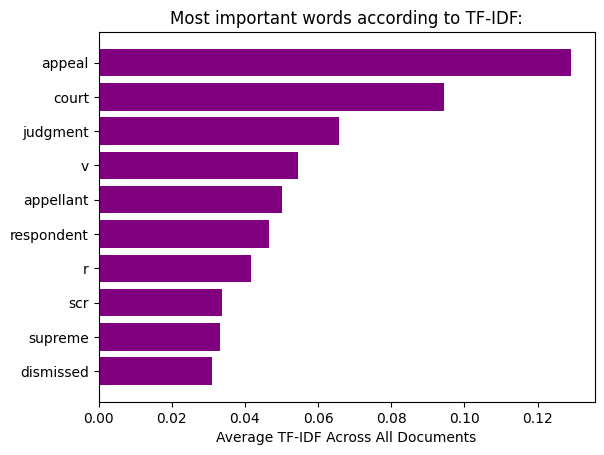

In [9]:
show_important_words_bar_plot(words_tfidf_scores, 'Most important words according to TF-IDF:', 'Average TF-IDF Across All Documents')

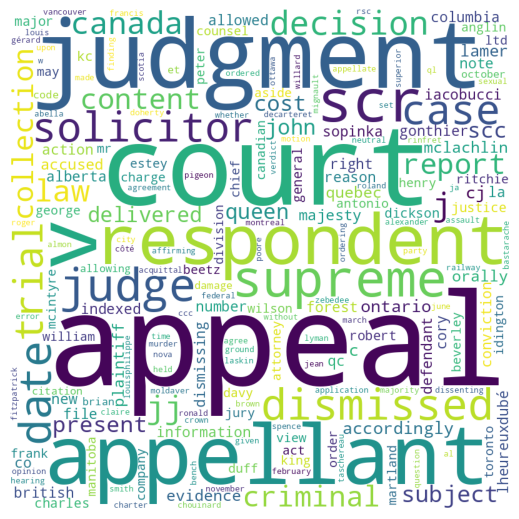

In [10]:
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = set(STOPWORDS),
                      collocations = False,
                      min_font_size = 10).generate(" ".join(new_corpus))

# plot the WordCloud image
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [11]:
Word2Vec_model = get_word2vec_model(token_mat, vector_size=10, min_freq_count=1)

In [12]:
words_sim_scores = get_most_frequent_embedded_words(tfidf_vectorizer, tfidf_mat, Word2Vec_model.wv, token_mat, 10)
eda_word_set.update(set([x[0] for x in words_sim_scores]))
print(words_sim_scores)

[('appeal', 3282.132447042565), ('respondent', 3205.186414669505), ('appellant', 3196.9632770453927), ('v', 1952.858694452342), ('court', 1738.4725011852984), ('judgment', 1368.4278251047922), ('scr', 984.2751321654209), ('solicitor', 946.6195202184039), ('dismissed', 890.1545893194798), ('date', 748.1093299031581)]


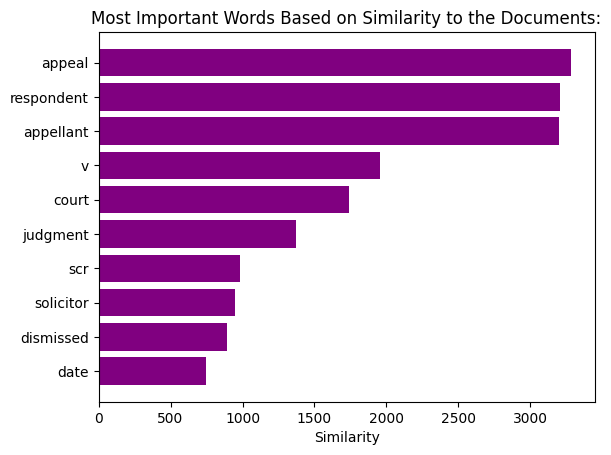

In [13]:
show_important_words_bar_plot(words_sim_scores, main_title='Most Important Words Based on Similarity to the Documents:', x_axis_title='Similarity')

In [14]:
word_representations = get_autoencoder_model(10, 5, Word2Vec_model.wv.vectors, tfidf_vectorizer.vocabulary_, batch_size=50, epochs=10)

Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1125
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0871
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2973
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -0.3839
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -0.4239
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -0.4439
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -0.4547
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -0.4622
Epoch 9/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -0.4669
Epoch 10/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -0.4706
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [15]:
words_sim_scores = get_most_frequent_embedded_words(tfidf_vectorizer, tfidf_mat, word_representations, token_mat, 10)
eda_word_set.update(set([x[0] for x in words_sim_scores]))
print(words_sim_scores)

[('appeal', 4429.552603112606), ('court', 1517.6628130709319), ('appellant', 803.8618440271003), ('date', 404.1485563074213), ('decision', 389.34152575938214), ('content', 315.2509149912039), ('judgment', 275.15788921610294), ('supreme', 229.85102399837157), ('collection', 216.5758114673892), ('c', 211.3020787314353)]


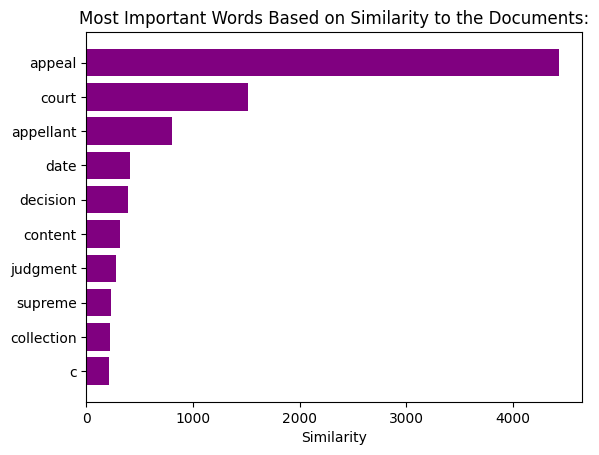

In [16]:
show_important_words_bar_plot(words_sim_scores, main_title='Most Important Words Based on Similarity to the Documents:', x_axis_title='Similarity')

<div dir="rtl">
סעיף (3) מתחשב במספר הפעמים שכל מילה מופיעה בכל קובץ ובמספר הקבצים הכוללים את המילה.<br> לכן, המילים החשובות ביותר יהיו אלו שהן הנפוצות היותר.<br>

בסעיף (4) מילים עם משמעות דומה יקבלו ייצוג קרוב אחד לשני, ואם משתמשים בגודל קטן, מילים דומות יתמזגו בייצוגן.<br>

בסעיף (5) אנחנו מקטינים את גודל הייצוג של כל מילה לייצוג מרוכז יותר.<br>
</div>

In [17]:
### NER ###
nlp = spacy.load('en_core_web_sm')

content = " ".join(new_corpus[:100])
doc = nlp(content)

entities = [(ent.lemma_, ent.label_) for ent in doc.ents]

eda_word_set.update(set([ent[0] for ent in entities if ent[1] == 'PERSON']))

In [18]:
#7 min
classifier = pipeline("sentiment-analysis", model='distilbert/distilbert-base-uncased-finetuned-sst-2-english', max_length=512, truncation=True)

sentiment_results = []
n = len(new_corpus)
for i, sentence in enumerate(new_corpus):
    sentiment_results.append(classifier(sentence)[0])
    if (i+1) % 50 == 0:
        print(f'{i+1}/{n} sentences completed', flush=True)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

50/929 sentences completed
100/929 sentences completed
150/929 sentences completed
200/929 sentences completed
250/929 sentences completed
300/929 sentences completed
350/929 sentences completed
400/929 sentences completed
450/929 sentences completed
500/929 sentences completed
550/929 sentences completed
600/929 sentences completed
650/929 sentences completed
700/929 sentences completed
750/929 sentences completed
800/929 sentences completed
850/929 sentences completed
900/929 sentences completed


In [19]:
df['sentiment'] = [res['label'] for res in sentiment_results]
print(len(df[df['sentiment'] == 'NEGATIVE']))
print(len(df[df['sentiment'] == 'POSITIVE']))

925
4


In [20]:
### EDA ###
print(len(eda_word_set), eda_word_set)

eda_results = {}
for phrase in eda_word_set:
  eda_results[phrase] = {'POSITIVE': 0, 'NEGATIVE': 0}
  for i, document in enumerate(new_corpus):
    if phrase in document:
      eda_results[phrase][df['sentiment'][i]] += 1

print(eda_results)

286 {'sandberg v ferguson', 'marie st onge ês nom', 'john duff lyman', 'sedgewick girouard nesbitt killam', 'taschereau henrielzéar', 'v moran scr date', 'anderson foster', 'hamilton city', 'sedgewick robert taschereau', 'george edwin', 'scott scr', 'scammell v clarke scr date', 'taschereau henrielzéar sedgewick robert mill davis', 'mey v simpson october', 'drouin pelletier baillargeon', 'frank madden', 'w nesbitt', 'patterson christopher salmon appeal', 'hamilton northwestern', 'al gould', 'al june', 'al oct', 'joseph deslongchamp', 'salmon canning', 'sedgewick king', 'henry strang', 'killam albert clements', 'blake qc w cassels qc', 'fawcett et', 'al v muggah presentsir', 'appellant', 'al v canadian', 'mccarthy', 'mccarthy qc', 'samuel henry fournier', 'mackie', 'al v manitoba', 'casey horton humphries', 'sedgewick robert girouard désiré', 'louis henry killam albert clements nesbitt wallace taschereau henrielzéar', 'james sedgewick robert appeal', 's pawnee v robert', 'v robinson', '

In [37]:
#initialize the summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

#get the summaries
summaries = summarize_documents(new_corpus[:50])

print('\n\n')
for s in summaries:
  print(s)
  print()

5/50 documents completed
10/50 documents completed
15/50 documents completed
20/50 documents completed
25/50 documents completed
30/50 documents completed
35/50 documents completed
40/50 documents completed
45/50 documents completed
50/50 documents completed



 eureka woollen mill co v moss collection supreme court judgment date report scr judge ritchie william johnstone fournier télesphore henry william alexander taschereau henrielzéar appeal nova scotia subject appeal decision content supreme court canada.

white v parker collection supreme court judgment date report scr judge ritchie william johnstone strong samuel henry patterson christopher salmon taschereau henrielzéar gwynne john wellington appeal supreme court new brunswick appealnew trialabatement actiondeath plaintiffactio personalis moritur cum person

Grand trunk railway co v fitzgerald collection supreme court judgment date report scr appeal ontario subject transportation decision content supreme court canada. grand trunk

In [33]:
#load pre-trained GPT-2 model and tokenizer
model_name = 'gpt2'
gpt_model = GPT2LMHeadModel.from_pretrained(model_name)
gpt_tokenizer = GPT2Tokenizer.from_pretrained(model_name)

#generate conclusion
conclusions = []
for i, document in enumerate(new_corpus[:50]):
  conclusions.append(gpt_generated_document_conclusion(gpt_model, gpt_tokenizer, document))
  if (i+1) % 5 == 0:
    print(f'{i+1}/50 documents completed', flush=True)

print('\n\n')
for c in conclusions:
  print(c)
  print()

5/50 documents completed
10/50 documents completed
15/50 documents completed
20/50 documents completed
25/50 documents completed
30/50 documents completed
35/50 documents completed
40/50 documents completed
45/50 documents completed
50/50 documents completed



eureka woollen mill co v moss collection supreme court judgment date report scr judge ritchie william johnstone fournier télesphore henry william alexander taschereau henrielzéar appeal nova scotia subject appeal decision content supreme court canada eureka woollen mill co v moss scr date eureka woollen mill company limited defendant appellant samuel moss et al plaintiff respondent oct presentsir w j ritchie cj fournier henry taschereau gwynne jj appeal supreme court nova scotia appeal new trial ordered court belowverdict weight evidence court hear appeal court exercise discretion ordered new trial ground verdict weight evidence appeal judgment supreme court nova scotia ordering new trial ground verdict appellant defendant weigh

In [36]:
#load pre-trained model and tokenizer
model_name = "facebook/bart-large-cnn"
bart_tokenizer = BartTokenizer.from_pretrained(model_name)
bart_model = BartForConditionalGeneration.from_pretrained(model_name)

#generate conclusion
conclusions = []
for i, document in enumerate(new_corpus[:50]):
  conclusions.append(bart_generated_document_conclusion(bart_model, bart_tokenizer, document))
  if (i+1) % 5 == 0:
    print(f'{i+1}/50 documents completed', flush=True)

print('\n\n')
for c in conclusions:
  print(c)
  print()

5/50 documents completed
10/50 documents completed
15/50 documents completed
20/50 documents completed
25/50 documents completed
30/50 documents completed
35/50 documents completed
40/50 documents completed
45/50 documents completed
50/50 documents completed



eureka woollen mill co v moss collection supreme court judgment date report scr judge ritchie william johnstone fournier télesphore henry william alexander taschereau henrielzéar

white v parker collection supreme court judgment date report scr judge ritchie william johnstone strong samuel henry patterson christopher salmon taschereau henrielzéar gwynne john wellington appeal new brunswick

grand trunk railway co v fitzgerald collection supreme court judgment date report scr appeal ontario subject transportation decision content supreme court canada. grand trunk railway Co v Fitzgerald scr date grand trunk company fitz Fitzgerald january june

bickford v hawkins collection supreme court judgment date report scr appeal ontario su

<div dir='rtl'>
מודל GPT משמש בעיקר בשביל יצירת טקסט (ג'נרוט) בלי התבוססות חזקה מדי על הטקסט המקורי.<br>
לדוגמה, יצירת המשך לטקסט, טקסט "יצירתי" או מענה על שאלות בעזרת שאילתות.<br>
במטלה, מודל ה-GPT מייצר לרוב ג'יבריש בסוף הסקת המסקנות.
<br>

מודל ברט מצטיין במטלות שמתבססות יותר על נתוני הקלט, לדוגמה, יצירת סיכום או ניתוח מסקנות מהטקסט.

</div>